In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import os

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.astype(np.float32).reshape(-1,28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1,28*28) / 255.0
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
def build_dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, activation = tf.nn.elu, initializer = tf.variance_scaling_initializer()):
  with tf.variable_scope(name, "dnn"):
    for layer in range(n_hidden_layers):
      inputs = tf.layers.dense(inputs, n_neurons, activation=activation, kernel_initializer = initializer, name="hidden%d" % (layer + 1))
    return inputs

In [ ]:
n_inputs = 28*28
n_outputs = 5
reset_graph()

X = tf.placeholder(tf.float32, shape = (None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = build_dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=tf.variance_scaling_initializer(), name = "logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name = "loss")

learning_rate=0.01

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [ ]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [ ]:
n_epochs = 1000
batch_size = 1000
max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
  init.run()

  for epoch in range(n_epochs):
    rnd_idx = np.random.permutation(len(X_train1))
    for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
      X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y:y_valid1})
    if loss_val < best_loss:
      save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
      best_loss = loss_val
      checks_without_progress = 0
    else:
      checks_without_progress+=1
      if checks_without_progress > max_checks_without_progress:
        print("Early stopping")
        break
    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
    
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.132040	Best loss: 0.132040	Accuracy: 95.58%
1	Validation loss: 0.082244	Best loss: 0.082244	Accuracy: 97.19%
2	Validation loss: 0.063801	Best loss: 0.063801	Accuracy: 97.89%
3	Validation loss: 0.051889	Best loss: 0.051889	Accuracy: 98.28%
4	Validation loss: 0.045413	Best loss: 0.045413	Accuracy: 98.55%
5	Validation loss: 0.041727	Best loss: 0.041727	Accuracy: 98.75%
6	Validation loss: 0.038230	Best loss: 0.038230	Accuracy: 98.79%
7	Validation loss: 0.042394	Best loss: 0.038230	Accuracy: 98.67%
8	Validation loss: 0.043667	Best loss: 0.038230	Accuracy: 98.55%
9	Validation loss: 0.040213	Best loss: 0.038230	Accuracy: 98.75%
10	Validation loss: 0.038084	Best loss: 0.038084	Accuracy: 98.94%
11	Validation loss: 0.043519	Best loss: 0.038084	Accuracy: 98.91%
12	Validation loss: 0.051770	Best loss: 0.038084	Accuracy: 98.71%
13	Validation loss: 0.054573	Best loss: 0.038084	Accuracy: 98.55%
14	Validation loss: 0.044813	Best loss: 0.038084	Accuracy: 99.02%
15	Validation loss: 

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=tf.variance_scaling_initializer(),
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=tf.variance_scaling_initializer(), name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [ ]:
dnn_clf = DNNClassifier(random_state=123)
dnn_clf.fit(X_train1, y_train1, n_epochs = 1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.111163	Best loss: 0.111163	Accuracy: 96.64%
1	Validation loss: 0.114591	Best loss: 0.111163	Accuracy: 97.42%
2	Validation loss: 0.585435	Best loss: 0.111163	Accuracy: 86.51%
3	Validation loss: 0.136425	Best loss: 0.111163	Accuracy: 97.65%
4	Validation loss: 0.141406	Best loss: 0.111163	Accuracy: 97.77%
5	Validation loss: 0.150558	Best loss: 0.111163	Accuracy: 98.28%
6	Validation loss: 0.182480	Best loss: 0.111163	Accuracy: 96.60%
7	Validation loss: 0.191427	Best loss: 0.111163	Accuracy: 95.74%
8	Validation loss: 0.166186	Best loss: 0.111163	Accuracy: 97.73%
9	Validation loss: 0.201733	Best loss: 0.111163	Accuracy: 96.60%
10	Validation loss: 0.180725	Best loss: 0.111163	Accuracy: 97.73%
11	Validation loss: 0.305429	Best loss: 0.111163	Accuracy: 97.46%
12	Validation loss: 0.636092	Best loss: 0.111163	Accuracy: 82.25%
13	Validation loss: 0.318474	Best loss: 0.111163	Accuracy: 95.74%
14	Validation loss: 0.356046	Best loss: 0.111163	Accuracy: 91.48%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f919e944400>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f917fd03ba8>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=123)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9657520918466628

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from functools import partial
def leaky_relu(alpha=0.01):
  def parametrized_leaky_relu(z, name = None):
    return tf.maximum(alpha *z, z, name=name)
  return parametrized_leaky_relu

params = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500, 1000, 2000],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    "n_hidden_layers": [1,2,3,4,5,6],
    "optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)]
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=123), params, n_iter=50, cv=3, random_state=123, verbose=2)

rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>, n_neurons=10, n_hidden_layers=2, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7f919e944400> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.082763	Best loss: 0.082763	Accuracy: 97.50%
1	Validation loss: 0.070283	Best loss: 0.070283	Accuracy: 97.85%
2	Validation loss: 0.079141	Best loss: 0.070283	Accuracy: 97.73%
3	Validation loss: 0.076060	Best loss: 0.070283	Accuracy: 97.85%
4	Validation loss: 0.097883	Best loss: 0.070283	Accuracy: 97.50%
5	Validation loss: 0.101422	Best loss: 0.070283	Accuracy: 97.34%
6	Validation loss: 0.075678	Best loss: 0.070283	Accuracy: 97.69%
7	Validation loss: 0.084964	Best loss: 0.070283	Accuracy: 97.97%
8	Validation loss: 0.071231	Best loss: 0.070283	Accuracy: 97.97%
9	Validation loss: 0.075023	Best loss: 0.070283	Accuracy: 98.05%
10	Validation loss: 0.081438	Best loss: 0.070283	Accuracy: 98.01%
11	Validation loss: 0.096682	Best loss: 0.070283	Accuracy: 97.30%
12	Validation loss: 0.086648	Best loss: 0.070283	Accuracy: 98.05%
13	Validation loss: 0.080003	Best loss: 0.070283	Accuracy: 97.85%
14	Validation loss: 0.083677	Best loss: 0.070283	Accuracy: 97.85%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
13	Validation loss: 0.056471	Best loss: 0.043297	Accuracy: 98.59%
14	Validation loss: 0.050161	Best loss: 0.043297	Accuracy: 98.67%
15	Validation loss: 0.052194	Best loss: 0.043297	Accuracy: 98.83%
16	Validation loss: 0.050244	Best loss: 0.043297	Accuracy: 98.67%
17	Validation loss: 0.055174	Best loss: 0.043297	Accuracy: 98.59%
18	Validation loss: 0.053849	Best loss: 0.043297	Accuracy: 98.59%
19	Validation loss: 0.049699	Best loss: 0.043297	Accuracy: 98.71%
20	Validation loss: 0.055265	Best loss: 0.043297	Accuracy: 98.44%
21	Validation loss: 0.055827	Best loss: 0.043297	Accuracy: 98.59%
22	Validation loss: 0.058924	Best loss: 0.043297	Accuracy: 98.59%
23	Validation loss: 0.058759	Best loss: 0.043297	Accuracy: 98.59%
24	Validation loss: 0.061696	Best loss: 0.043297	Accuracy: 98.59%
25	Validation loss: 0.060086	Best loss: 0.043297	Accuracy: 98.59%
26	Validation loss: 0.061196	Best loss: 0.043297	Accuracy: 98.55%
27	Validation loss: 0.061

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 49.1min finished


0	Validation loss: 0.078498	Best loss: 0.078498	Accuracy: 97.46%
1	Validation loss: 0.061721	Best loss: 0.061721	Accuracy: 98.16%
2	Validation loss: 0.054280	Best loss: 0.054280	Accuracy: 98.20%
3	Validation loss: 0.035543	Best loss: 0.035543	Accuracy: 98.83%
4	Validation loss: 0.037169	Best loss: 0.035543	Accuracy: 98.91%
5	Validation loss: 0.035963	Best loss: 0.035543	Accuracy: 98.83%
6	Validation loss: 0.029550	Best loss: 0.029550	Accuracy: 98.98%
7	Validation loss: 0.026960	Best loss: 0.026960	Accuracy: 99.14%
8	Validation loss: 0.032416	Best loss: 0.026960	Accuracy: 99.06%
9	Validation loss: 0.037271	Best loss: 0.026960	Accuracy: 98.94%
10	Validation loss: 0.026963	Best loss: 0.026960	Accuracy: 99.26%
11	Validation loss: 0.034959	Best loss: 0.026960	Accuracy: 99.14%
12	Validation loss: 0.039745	Best loss: 0.026960	Accuracy: 98.98%
13	Validation loss: 0.031938	Best loss: 0.026960	Accuracy: 99.34%
14	Validation loss: 0.036751	Best loss: 0.026960	Accuracy: 99.22%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DNNClassifier(activation=<function elu at 0x7f919e944400>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f917fd03ba8>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.python.training.adam...
                                                          0.1],
                                        'n_hidden_layers': [1, 2, 3, 4, 5, 6],
                                        'n_neurons': [10, 30, 50, 70, 90, 100,
                                                      120, 140, 160],
                                        'optimizer_class': [

In [ ]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 100,
 'learning_rate': 0.02,
 'n_hidden_layers': 6,
 'n_neurons': 100,
 'optimizer_class': functools.partial(<class 'tensorflow.python.training.momentum.MomentumOptimizer'>, momentum=0.95)}

In [ ]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9926055652850749

In [ ]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

In [ ]:
dnn_clf_bst = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=100, learning_rate=0.02, n_hidden_layers=6, n_neurons=100, optimizer_class=partial(tf.train.MomentumOptimizer, momentum=0.95), batch_norm_momentum=0.95)

dnn_clf_bst.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
0	Validation loss: 0.042255	Best loss: 0.042255	Accuracy: 98.55%
1	Validation loss: 0.039161	Best loss: 0.039161	Accuracy: 98.71%
2	Validation loss: 0.030764	Best loss: 0.030764	Accuracy: 99.14%
3	Validation loss: 0.031116	Best loss: 0.030764	Accuracy: 98.94%
4	Validation loss: 0.032329	Best loss: 0.030764	Accuracy: 99.06%
5	Validation loss: 0.030276	Best loss: 0.030276	Accuracy: 99.14%
6	Validation loss: 0.033644	Best loss: 0.030276	Accuracy: 98.91%
7	Validation loss: 0.026955	Best loss: 0.026955	Accuracy: 99.22%
8	Validation loss: 0.030540	Best loss: 0.026955	Accuracy: 99.22%
9	Validation loss: 0.024740	Best loss: 0.024740	Accuracy: 99.18%
10	Validation loss: 0.029556	Best loss: 0.024740	Accuracy: 99.26%
11	Validation loss: 0.026108	Best loss: 0.024740	Accuracy: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f91768a2a60>,
              batch_norm_momentum=0.95, batch_size=100, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f917fd03ba8>,
              learning_rate=0.02, n_hidden_layers=6, n_neurons=100,
              optimizer_class=functools.partial(<class 'tensorflow.python.training.momentum.MomentumOptimizer'>, momentum=0.95),
              random_state=None)

In [ ]:
accuracy_score(y_test1, dnn_clf_bst.predict(X_test1))

0.9943568787701887

In [ ]:
dnn_clf_bst_2 = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=200, learning_rate=0.02, n_hidden_layers=6, n_neurons=100, optimizer_class=partial(tf.train.MomentumOptimizer, momentum=0.95), batch_norm_momentum=0.95)

dnn_clf_bst_2.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

0	Validation loss: 0.049810	Best loss: 0.049810	Accuracy: 98.28%
1	Validation loss: 0.037511	Best loss: 0.037511	Accuracy: 98.83%
2	Validation loss: 0.031992	Best loss: 0.031992	Accuracy: 99.14%
3	Validation loss: 0.029845	Best loss: 0.029845	Accuracy: 98.79%
4	Validation loss: 0.038227	Best loss: 0.029845	Accuracy: 98.79%
5	Validation loss: 0.030259	Best loss: 0.029845	Accuracy: 99.02%
6	Validation loss: 0.026507	Best loss: 0.026507	Accuracy: 99.10%
7	Validation loss: 0.026263	Best loss: 0.026263	Accuracy: 98.98%
8	Validation loss: 0.026691	Best loss: 0.026263	Accuracy: 99.06%
9	Validation loss: 0.030569	Best loss: 0.026263	Accuracy: 99.14%
10	Validation loss: 0.036153	Best loss: 0.026263	Accuracy: 98.94%
11	Validation loss: 0.029013	Best loss: 0.026263	Accuracy: 99.18%
12	Validation loss: 0.030907	Best loss: 0.026263	Accuracy: 99.14%
13	Validation loss: 0.034684	Best loss: 0.026263	Accuracy: 99.06%
14	Validation loss: 0.031092	Best loss: 0.026263	Accuracy: 99.18%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f91702ffbf8>,
              batch_norm_momentum=0.95, batch_size=200, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f917fd03ba8>,
              learning_rate=0.02, n_hidden_layers=6, n_neurons=100,
              optimizer_class=functools.partial(<class 'tensorflow.python.training.momentum.MomentumOptimizer'>, momentum=0.95),
              random_state=None)

In [ ]:
accuracy_score(y_test1, dnn_clf_bst_2.predict(X_test1))

0.9945514691574237

In [ ]:
dnn_clf_bst_2.save("./my_best_mnist_model_0_to_4")

Better performance on test than validation set so I will choose dnn_clf_bst_2

In [ ]:
reset_graph()
restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

learning_rate = 0.01

output_layers_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.MomentumOptimizer(learning_rate,momentum=0.95, name="Optimizer2")
training_op = optimizer.minimize(loss, var_list=output_layers_vars)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

In [ ]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

In [ ]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [ ]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [ ]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.941377	Best loss: 1.941377	Accuracy: 40.67%
1	Validation loss: 0.897786	Best loss: 0.897786	Accuracy: 58.67%
2	Validation loss: 0.820039	Best loss: 0.820039	Accuracy: 69.33%
3	Validation loss: 0.786171	Best loss: 0.786171	Accuracy: 72.00%
4	Validation loss: 0.666517	Best loss: 0.666517	Accuracy: 78.00%
5	Validation loss: 0.689198	Best loss: 0.666517	Accuracy: 78.00%
6	Validation loss: 0.673250	Best loss: 0.666517	Accuracy: 77.33%
7	Validation loss: 0.648762	Best loss: 0.648762	Accuracy: 80.00%
8	Validation loss: 0.679353	Best loss: 0.648762	Accuracy: 78.67%
9	Validation loss: 0.635606	Best loss: 0.635606	Accuracy: 80.00%
10	Validation loss: 0.629063	Best loss: 0.629063	Accuracy: 80.67%
11	Validation loss: 0.640375	Best loss: 0.629063	Accuracy: 79.33%
12	Validation loss: 0.632337	Best loss: 0.629063	Accuracy: 78.67%
13	Validation loss: 0.631124	Best loss: 0.629063	Accuracy: 80.00%
14	Validation l

In [ ]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

In [ ]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.904352	Best loss: 1.904352	Accuracy: 44.67%
1	Validation loss: 0.941510	Best loss: 0.941510	Accuracy: 56.00%
2	Validation loss: 0.802781	Best loss: 0.802781	Accuracy: 69.33%
3	Validation loss: 0.747189	Best loss: 0.747189	Accuracy: 75.33%
4	Validation loss: 0.703785	Best loss: 0.703785	Accuracy: 74.67%
5	Validation loss: 0.691255	Best loss: 0.691255	Accuracy: 78.00%
6	Validation loss: 0.660145	Best loss: 0.660145	Accuracy: 77.33%
7	Validation loss: 0.657754	Best loss: 0.657754	Accuracy: 78.00%
8	Validation loss: 0.685653	Best loss: 0.657754	Accuracy: 77.33%
9	Validation loss: 0.628150	Best loss: 0.628150	Accuracy: 79.33%
10	Validation loss: 0.624923	Best loss: 0.624923	Accuracy: 81.33%
11	Validation loss: 0.651456	Best loss: 0.624923	Accuracy: 78.67%
12	Validation loss: 0.645850	Best loss: 0.624923	Accuracy: 76.67%
13	Validation loss: 0.639197	Best loss: 0.624923	Accuracy: 80.00%
14	Validation l

In [ ]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=tf.variance_scaling_initializer(), name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.MomentumOptimizer(learning_rate,momentum=0.95, name="Optimizer2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.843036	Best loss: 0.843036	Accuracy: 73.33%
1	Validation loss: 0.631986	Best loss: 0.631986	Accuracy: 81.33%
2	Validation loss: 0.577161	Best loss: 0.577161	Accuracy: 79.33%
3	Validation loss: 0.582780	Best loss: 0.577161	Accuracy: 79.33%
4	Validation loss: 0.534820	Best loss: 0.534820	Accuracy: 79.33%
5	Validation loss: 0.541942	Best loss: 0.534820	Accuracy: 81.33%
6	Validation loss: 0.536923	Best loss: 0.534820	Accuracy: 83.33%
7	Validation loss: 0.525572	Best loss: 0.525572	Accuracy: 82.67%
8	Validation loss: 0.527916	Best loss: 0.525572	Accuracy: 84.00%
9	Validation loss: 0.517758	Best loss: 0.517758	Accuracy: 82.67%
10	Validation loss: 0.509466	Best loss: 0.509466	Accuracy: 83.33%
11	Validation loss: 0.506970	Best loss: 0.506970	Accuracy: 83.33%
12	Validation loss: 0.506178	Best loss: 0.506178	Accuracy: 84.00%
13	Validation loss: 0.511540	Best loss: 0.506178	Accuracy: 82.67%
14	Validation l

In [ ]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.MomentumOptimizer(learning_rate,momentum=0.95, name="Optimizer3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.800554	Best loss: 0.800554	Accuracy: 72.67%
1	Validation loss: 0.446614	Best loss: 0.446614	Accuracy: 86.00%
2	Validation loss: 0.345467	Best loss: 0.345467	Accuracy: 92.00%
3	Validation loss: 0.613376	Best loss: 0.345467	Accuracy: 88.00%
4	Validation loss: 0.390862	Best loss: 0.345467	Accuracy: 90.67%
5	Validation loss: 0.431618	Best loss: 0.345467	Accuracy: 91.33%
6	Validation loss: 0.407797	Best loss: 0.345467	Accuracy: 89.33%
7	Validation loss: 0.409916	Best loss: 0.345467	Accuracy: 89.33%
8	Validation loss: 0.418517	Best loss: 0.345467	Accuracy: 91.33%
9	Validation loss: 0.331423	Best loss: 0.331423	Accuracy: 92.67%
10	Validation loss: 0.330411	Best loss: 0.330411	Accuracy: 92.67%
11	Validation loss: 0.344637	Best loss: 0.330411	Accuracy: 92.67%
12	Validation loss: 0.344657	Best loss: 0.330411	Accuracy: 92.67%
13	Validation loss: 0.346710	Best loss: 0.330411	Accuracy: 92.67%
14	Valid

In [ ]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=123)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.787992	Best loss: 0.787992	Accuracy: 79.33%
1	Validation loss: 0.528987	Best loss: 0.528987	Accuracy: 86.67%
2	Validation loss: 0.546787	Best loss: 0.528987	Accuracy: 90.00%
3	Validation loss: 0.629830	Best loss: 0.528987	Accuracy: 88.67%
4	Validation loss: 0.487983	Best loss: 0.487983	Accuracy: 88.00%
5	Validation loss: 0.702590	Best loss: 0.487983	Accuracy: 86.67%
6	Validation loss: 0.866880	Best loss: 0.487983	Accuracy: 88.00%
7	Validation loss: 0.989610	Best loss: 0.487983	Accuracy: 87.33%
8	Validation loss: 0.950766	Best loss: 0.487983	Accuracy: 90.00%
9	Validation loss: 0.770552	Best loss: 0.487983	Accuracy: 90.00%
10	Validation loss: 0.990658	Best loss: 0.487983	Accuracy: 90.67%
11	Validation loss: 1.012034	Best loss: 0.487983	Accuracy: 87.33%
12	Validation loss: 2.108945	Best loss: 0.487983	Accuracy: 80.67%
13	Validation loss: 0.704510	Best loss: 0.487983	Accuracy: 87.33%
14	Validation loss: 0.919822	Best loss: 0.487983	Accuracy: 86.67%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f919e944400>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f917fd03ba8>,
              learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=123)

In [ ]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8693684427072619

In [ ]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

y = tf.placeholder(tf.int32, shape=[None, 1])

dnn1 = build_dnn(X1, name="DNN_A")
dnn2 = build_dnn(X2, name="DNN_B")

dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=tf.variance_scaling_initializer())
logits = tf.layers.dense(hidden, units=1, kernel_initializer=tf.variance_scaling_initializer())
y_proba = tf.nn.sigmoid(logits)
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [ ]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [ ]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [ ]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

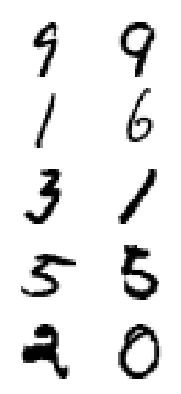

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [ ]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [ ]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [ ]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.6910327
0 Test accuracy: 0.542
1 Train loss: 0.60353535
2 Train loss: 0.54946035
3 Train loss: 0.47047246
4 Train loss: 0.40607572
5 Train loss: 0.3830816
5 Test accuracy: 0.824
6 Train loss: 0.39047274
7 Train loss: 0.33907944
8 Train loss: 0.32106712
9 Train loss: 0.31792694
10 Train loss: 0.24494292
10 Test accuracy: 0.8881
11 Train loss: 0.2929235
12 Train loss: 0.23225458
13 Train loss: 0.23180935
14 Train loss: 0.19877912
15 Train loss: 0.20065476
15 Test accuracy: 0.9203
16 Train loss: 0.19700494
17 Train loss: 0.18893103
18 Train loss: 0.1996545
19 Train loss: 0.24071668
20 Train loss: 0.18882008
20 Test accuracy: 0.9367
21 Train loss: 0.124191776
22 Train loss: 0.1401339
23 Train loss: 0.120789275
24 Train loss: 0.15721098
25 Train loss: 0.1150786
25 Test accuracy: 0.948
26 Train loss: 0.13891102
27 Train loss: 0.15260781
28 Train loss: 0.12343691
29 Train loss: 0.11543126
30 Train loss: 0.1140289
30 Test accuracy: 0.9507
31 Train loss: 0.11896972
32 Train loss

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = build_dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=tf.variance_scaling_initializer())
# Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [ ]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9724
10 Test accuracy: 0.9743
20 Test accuracy: 0.9738
30 Test accuracy: 0.9726
40 Test accuracy: 0.9734
50 Test accuracy: 0.9728
60 Test accuracy: 0.973
70 Test accuracy: 0.973
80 Test accuracy: 0.9726
90 Test accuracy: 0.9732


In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = build_dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=tf.variance_scaling_initializer())
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [ ]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8694
10 Test accuracy: 0.9276
20 Test accuracy: 0.9345
30 Test accuracy: 0.9419
40 Test accuracy: 0.9431
50 Test accuracy: 0.943
60 Test accuracy: 0.9429
70 Test accuracy: 0.943
80 Test accuracy: 0.9431
90 Test accuracy: 0.9431
100 Test accuracy: 0.9433
110 Test accuracy: 0.9434
120 Test accuracy: 0.9435
130 Test accuracy: 0.9434
140 Test accuracy: 0.9435
